In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from LDGD.model import ARDRBFKernel, LDGD
from LDGD.model.experimental.GP_scratch import bGPLVM
from LDGD.visualization import plot_box_plots
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.mlls import VariationalELBO
import gpytorch
import numpy as np
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt
import json
import winsound

from LDGD.visualization.vizualize_utils import plot_heatmap, plot_2d_scatter, plot_ARD_gplvm
from LDGD.visualization.vizualize_utils import plot_loss_gplvm, plot_scatter_gplvm, plot_box_plots

In [2]:
np.random.seed(42)
torch.manual_seed(42)

duration = 1000  # milliseconds
freq = 440  # Hz
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def train_model(data_cont, data_cat, settings, filename):
    num_points, data_dim = data_cont.shape
    batch_shape = torch.Size([data_dim])
    settings['use_gpytorch'] = True
    if settings['use_gpytorch'] is False:
        kernel_cls = ARDRBFKernel(input_dim=settings['latent_dim'])
        kernel_reg = ARDRBFKernel(input_dim=settings['latent_dim'])
    else:
        kernel_reg = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=settings['latent_dim']))
        kernel_cls = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=settings['latent_dim']))

    likelihood_reg = GaussianLikelihood(batch_shape=batch_shape)
    likelihood_cls = BernoulliLikelihood()


    if settings['load_model'] is True:
        with open(f'./saved_models/fig2_ldgd_{filename}_settings.json', 'r') as file:
            settings = json.load(file)
        model = LDGD(data_cont,
                kernel_reg=kernel_reg,
                kernel_cls=kernel_cls,
                num_classes=data_cat.shape[-1],
                num_inducing_points_cls=settings['num_inducing_points_cls'],
                num_inducing_points_reg=settings['num_inducing_points_reg'],
                latent_dim=settings['latent_dim'],
                likelihood_reg=likelihood_reg,
                likelihood_cls=likelihood_cls,
                use_gpytorch=settings['use_gpytorch'],
                shared_inducing_points=settings['shared_inducing_points'],
                x_init=settings['x_init'])
        model.load_weights(path_save='./saved_models/', file_name=f"fig2_ldgd_{filename}.pth")
        history_train = model.history_train
        losses = model.history_train['elbo_loss']
    else:
        model = LDGD(data_cont,
                kernel_reg=kernel_reg,
                kernel_cls=kernel_cls,
                num_classes=data_cat.shape[-1],
                num_inducing_points_cls=settings['num_inducing_points_cls'],
                num_inducing_points_reg=settings['num_inducing_points_reg'],
                latent_dim=settings['latent_dim'],
                likelihood_reg=likelihood_reg,
                likelihood_cls=likelihood_cls,
                use_gpytorch=settings['use_gpytorch'],
                shared_inducing_points=settings['shared_inducing_points'],
                x_init=settings['x_init'])

        losses, history_train = model.train_model(yn=data_cont,
                                                  ys=data_cat,
                                                  epochs=settings['num_epochs_train'],
                                                  batch_size=settings['batch_size'])

        if settings['save_model'] is True:
            model.save_wights(path_save='./saved_models/', file_name=f"fig2_ldgd_{filename}")
        with open(f'./saved_models/fig2_ldgd_{filename}_settings.json', 'w') as f:
            json.dump(settings, f)
    return model, losses, history_train, model_settings


# Load Oil dataset

In [4]:
train_data_oil = np.load('../data/train_data.npy', allow_pickle=True)
test_data_oil = np.load('../data/test_data.npy', allow_pickle=True)

yn_train_oil, ys_train_oil, labels_train_oil = train_data_oil.take(0)['yn_train'], train_data_oil.take(0)['ys_train'], train_data_oil.take(0)['labels_train']
yn_test_oil, ys_test_oil, labels_test_oil = test_data_oil.take(0)['yn_test'], test_data_oil.take(0)['ys_test'], test_data_oil.take(0)['labels_test']

yn_train_oil, ys_train_oil, labels_train_oil = torch.Tensor(yn_train_oil), torch.Tensor(ys_train_oil), torch.Tensor(labels_train_oil)
yn_test_oil, ys_test_oil, labels_test_oil = torch.Tensor(yn_test_oil), torch.Tensor(ys_test_oil), torch.Tensor(labels_test_oil)

print(f"Train size : {yn_train_oil.shape[0]} Test size : {yn_test_oil.shape[0]}")

Train size : 800 Test size : 200


# Load IRIS dataset

In [5]:
train_data_iris = np.load('../data/train_data_iris.npy', allow_pickle=True)
test_data_iris = np.load('../data/test_data_iris.npy', allow_pickle=True)

yn_train_iris, ys_train_iris, labels_train_iris = train_data_iris.take(0)['yn_train'], train_data_iris.take(0)['ys_train'], train_data_iris.take(0)['labels_train']
yn_test_iris, ys_test_iris, labels_test_iris = test_data_iris.take(0)['yn_test'], test_data_iris.take(0)['ys_test'], test_data_iris.take(0)['labels_test']

yn_train_iris, ys_train_iris, labels_train_iris = torch.Tensor(yn_train_iris), torch.Tensor(ys_train_iris), torch.Tensor(labels_train_iris)
yn_test_iris, ys_test_iris, labels_test_iris = torch.Tensor(yn_test_iris), torch.Tensor(ys_test_iris), torch.Tensor(labels_test_iris)

print(f"Train size : {yn_train_iris.shape[0]} Test size : {yn_test_iris.shape[0]}")


Train size : 120 Test size : 30


# LDGD
## Oil flow

In [24]:
model_settings = {
    'latent_dim': 7,
    'num_inducing_points_reg': 25,
    'num_inducing_points_cls': 25,
    'num_epochs_train': 3000,
    'num_epochs_test': 3000,
    'batch_size': 2000,
    'load_trained_model': False,
    'load_tested_model': False,
    'use_gpytorch': True,
    'save_model': True,
    'load_model':False,
    'x_init': 'pca',
    'shared_inducing_points': False
}

In [25]:

model_oil, losses_oil, history_train_oil, model_settings = train_model(data_cont = yn_train_oil,
                                                                       data_cat = ys_train_oil,
                                                                       settings = model_settings,
                                                                       filename = 'oil')
winsound.Beep(freq, duration*3)

Epoch 1/3000, Loss: 22.742246627807617
Epoch 11/3000, Loss: 21.850683212280273
Epoch 21/3000, Loss: 20.926563262939453
Epoch 31/3000, Loss: 19.848108291625977
Epoch 41/3000, Loss: 18.693376541137695
Epoch 51/3000, Loss: 17.52887725830078
Epoch 61/3000, Loss: 16.477468490600586
Epoch 71/3000, Loss: 15.346003532409668
Epoch 81/3000, Loss: 14.364541053771973
Epoch 91/3000, Loss: 13.411772727966309
Epoch 101/3000, Loss: 12.663130760192871
Epoch 111/3000, Loss: 11.785170555114746
Epoch 121/3000, Loss: 10.947509765625
Epoch 131/3000, Loss: 10.018963813781738
Epoch 141/3000, Loss: 9.120513916015625
Epoch 151/3000, Loss: 8.344257354736328
Epoch 161/3000, Loss: 7.471369743347168
Epoch 171/3000, Loss: 6.782320499420166
Epoch 181/3000, Loss: 5.9184417724609375
Epoch 191/3000, Loss: 5.178799152374268
Epoch 201/3000, Loss: 4.402576923370361
Epoch 211/3000, Loss: 3.709817886352539
Epoch 221/3000, Loss: 3.0625529289245605
Epoch 231/3000, Loss: 2.3524117469787598
Epoch 241/3000, Loss: 1.67869818210601

In [26]:
predictions_oil, metrics_oil, history_test = model_oil.evaluate(yn_test=yn_test_oil, ys_test=labels_test_oil, epochs=model_settings['num_epochs_test'])

alpha_reg_oil = 1 / model_oil.kernel_reg.base_kernel.lengthscale.cpu().detach().numpy()
alpha_cls_oil = 1 / model_oil.kernel_cls.base_kernel.lengthscale.cpu().detach().numpy()

x_oil = model_oil.x.q_mu.cpu().detach().numpy()
std_oil = torch.nn.functional.softplus(model_oil.x.q_log_sigma).cpu().detach().numpy()

x_test_oil = model_oil.x_test.q_mu.cpu().detach().numpy()
std_test_oil = torch.nn.functional.softplus(model_oil.x_test.q_log_sigma).cpu().detach().numpy()
winsound.Beep(freq, duration)

Epoch 1/3000, Loss: 9416.0009765625
Epoch 11/3000, Loss: 9137.6142578125
Epoch 21/3000, Loss: 8224.3359375
Epoch 31/3000, Loss: 7632.38330078125
Epoch 41/3000, Loss: 8876.7705078125
Epoch 51/3000, Loss: 7868.6025390625
Epoch 61/3000, Loss: 6585.32275390625
Epoch 71/3000, Loss: 5826.57958984375
Epoch 81/3000, Loss: 5644.81005859375
Epoch 91/3000, Loss: 5326.5185546875
Epoch 101/3000, Loss: 6285.08740234375
Epoch 111/3000, Loss: 5530.09228515625
Epoch 121/3000, Loss: 5503.525390625
Epoch 131/3000, Loss: 4488.59814453125
Epoch 141/3000, Loss: 4510.00146484375
Epoch 151/3000, Loss: 4449.5830078125
Epoch 161/3000, Loss: 4148.80810546875
Epoch 171/3000, Loss: 4120.86474609375
Epoch 181/3000, Loss: 3688.247314453125
Epoch 191/3000, Loss: 3674.19384765625
Epoch 201/3000, Loss: 3237.896240234375
Epoch 211/3000, Loss: 3179.451904296875
Epoch 221/3000, Loss: 3204.596923828125
Epoch 231/3000, Loss: 2967.034423828125
Epoch 241/3000, Loss: 2929.246826171875
Epoch 251/3000, Loss: 2952.056396484375
Ep

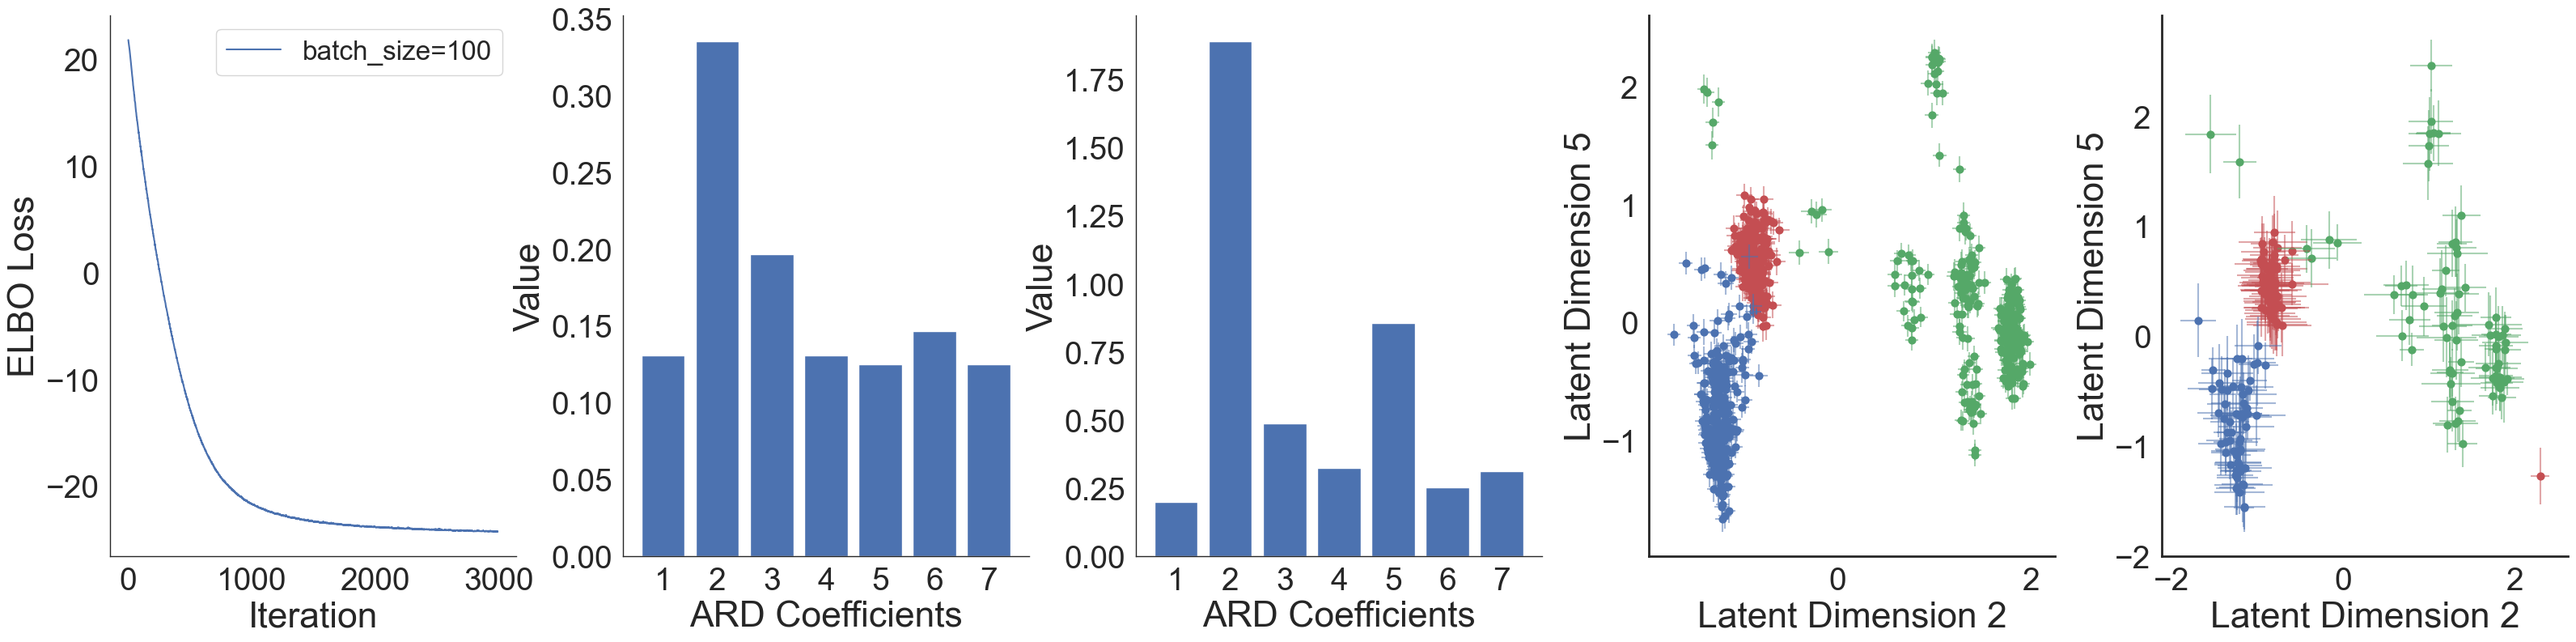

In [27]:
latent_dim = x_oil.shape[-1]
values, indices = torch.topk(torch.tensor(alpha_cls_oil), k=2, largest=True)
l1 = indices.numpy().flatten()[0]
l2 = indices.numpy().flatten()[1]

fig, axs = plt.subplots(1,5, figsize=(32, 8))


plot_loss_gplvm(losses_oil, ax=axs[0])
plot_ARD_gplvm(latent_dim, alpha_cls_oil, ax=axs[2])
plot_ARD_gplvm(latent_dim, alpha_reg_oil, ax=axs[1])
plot_scatter_gplvm(x_oil, labels_train_oil, l1=l1, l2=l2, ax=axs[3], colors=['r', 'b', 'g'], show_errorbars=True, std=np.sqrt(std_oil))
plot_scatter_gplvm(x_test_oil, labels_test_oil, l1=l1, l2=l2, ax=axs[4], colors=['r', 'b', 'g'], show_errorbars=True, std=np.sqrt(std_test_oil))
plt.tight_layout()


# Iris

In [10]:
model_settings = {
    'latent_dim': 7,
    'num_inducing_points_reg': 15,
    'num_inducing_points_cls': 15,
    'num_epochs_train': 2000,
    'num_epochs_test': 2000,
    'batch_size': 500,
    'load_trained_model': False,
    'load_tested_model': False,
    'use_gpytorch': True,
    'save_model': True,
    'load_model':True,
    'x_init': None,
    'shared_inducing_points': True
}

model_iris, losses_iris, history_train_iris, model_settings = train_model(data_cont = yn_train_iris,
                                                                          data_cat = ys_train_iris,
                                                                          settings = model_settings,
                                                                          filename = 'iris')
winsound.Beep(freq, duration*2)

Epoch 1/2000, Loss: 54.66524887084961
Epoch 11/2000, Loss: 51.11941909790039
Epoch 21/2000, Loss: 47.870059967041016
Epoch 31/2000, Loss: 44.82822799682617
Epoch 41/2000, Loss: 41.87502670288086
Epoch 51/2000, Loss: 38.281219482421875
Epoch 61/2000, Loss: 34.46570587158203
Epoch 71/2000, Loss: 30.441186904907227
Epoch 81/2000, Loss: 25.69817543029785
Epoch 91/2000, Loss: 20.642946243286133
Epoch 101/2000, Loss: 16.599700927734375
Epoch 111/2000, Loss: 13.533042907714844
Epoch 121/2000, Loss: 11.14338493347168
Epoch 131/2000, Loss: 10.927695274353027
Epoch 141/2000, Loss: 9.931131362915039
Epoch 151/2000, Loss: 9.523980140686035
Epoch 161/2000, Loss: 9.157286643981934
Epoch 171/2000, Loss: 8.899681091308594
Epoch 181/2000, Loss: 8.941152572631836
Epoch 191/2000, Loss: 8.63879108428955
Epoch 201/2000, Loss: 8.276519775390625
Epoch 211/2000, Loss: 8.510110855102539
Epoch 221/2000, Loss: 8.213438987731934
Epoch 231/2000, Loss: 8.075841903686523
Epoch 241/2000, Loss: 7.875575065612793
Epoch

In [11]:
predictions_iris, metrics_iris, history_test = model_iris.evaluate(yn_test=yn_test_iris, ys_test=labels_test_iris, epochs=2000)

alpha_reg_iris = 1 / model_iris.kernel_reg.base_kernel.lengthscale.cpu().detach().numpy()
alpha_cls_iris = 1 / model_iris.kernel_cls.base_kernel.lengthscale.cpu().detach().numpy()

x_iris = model_iris.x.q_mu.cpu().detach().numpy()
std_iris = torch.nn.functional.softplus(model_iris.x.q_log_sigma).cpu().detach().numpy()

x_test_iris = model_iris.x_test.q_mu.cpu().detach().numpy()
std_test_iris = torch.nn.functional.softplus(model_iris.x_test.q_log_sigma).cpu().detach().numpy()
winsound.Beep(freq, duration)

Epoch 1/2000, Loss: 283.0401916503906
Epoch 11/2000, Loss: 282.7454528808594
Epoch 21/2000, Loss: 264.4605407714844
Epoch 31/2000, Loss: 179.14602661132812
Epoch 41/2000, Loss: 235.32733154296875
Epoch 51/2000, Loss: 155.2004852294922
Epoch 61/2000, Loss: 132.7276153564453
Epoch 71/2000, Loss: 118.87860870361328
Epoch 81/2000, Loss: 156.8383331298828
Epoch 91/2000, Loss: 72.12010192871094
Epoch 101/2000, Loss: 126.27879333496094
Epoch 111/2000, Loss: 92.38407897949219
Epoch 121/2000, Loss: 82.75608825683594
Epoch 131/2000, Loss: 81.17996215820312
Epoch 141/2000, Loss: 77.60763549804688
Epoch 151/2000, Loss: 41.160667419433594
Epoch 161/2000, Loss: 38.496639251708984
Epoch 171/2000, Loss: 90.73033905029297
Epoch 181/2000, Loss: 57.49435806274414
Epoch 191/2000, Loss: 68.87126922607422
Epoch 201/2000, Loss: 37.21240234375
Epoch 211/2000, Loss: 46.772674560546875
Epoch 221/2000, Loss: 67.8924331665039
Epoch 231/2000, Loss: 36.09087371826172
Epoch 241/2000, Loss: 36.78795623779297
Epoch 25

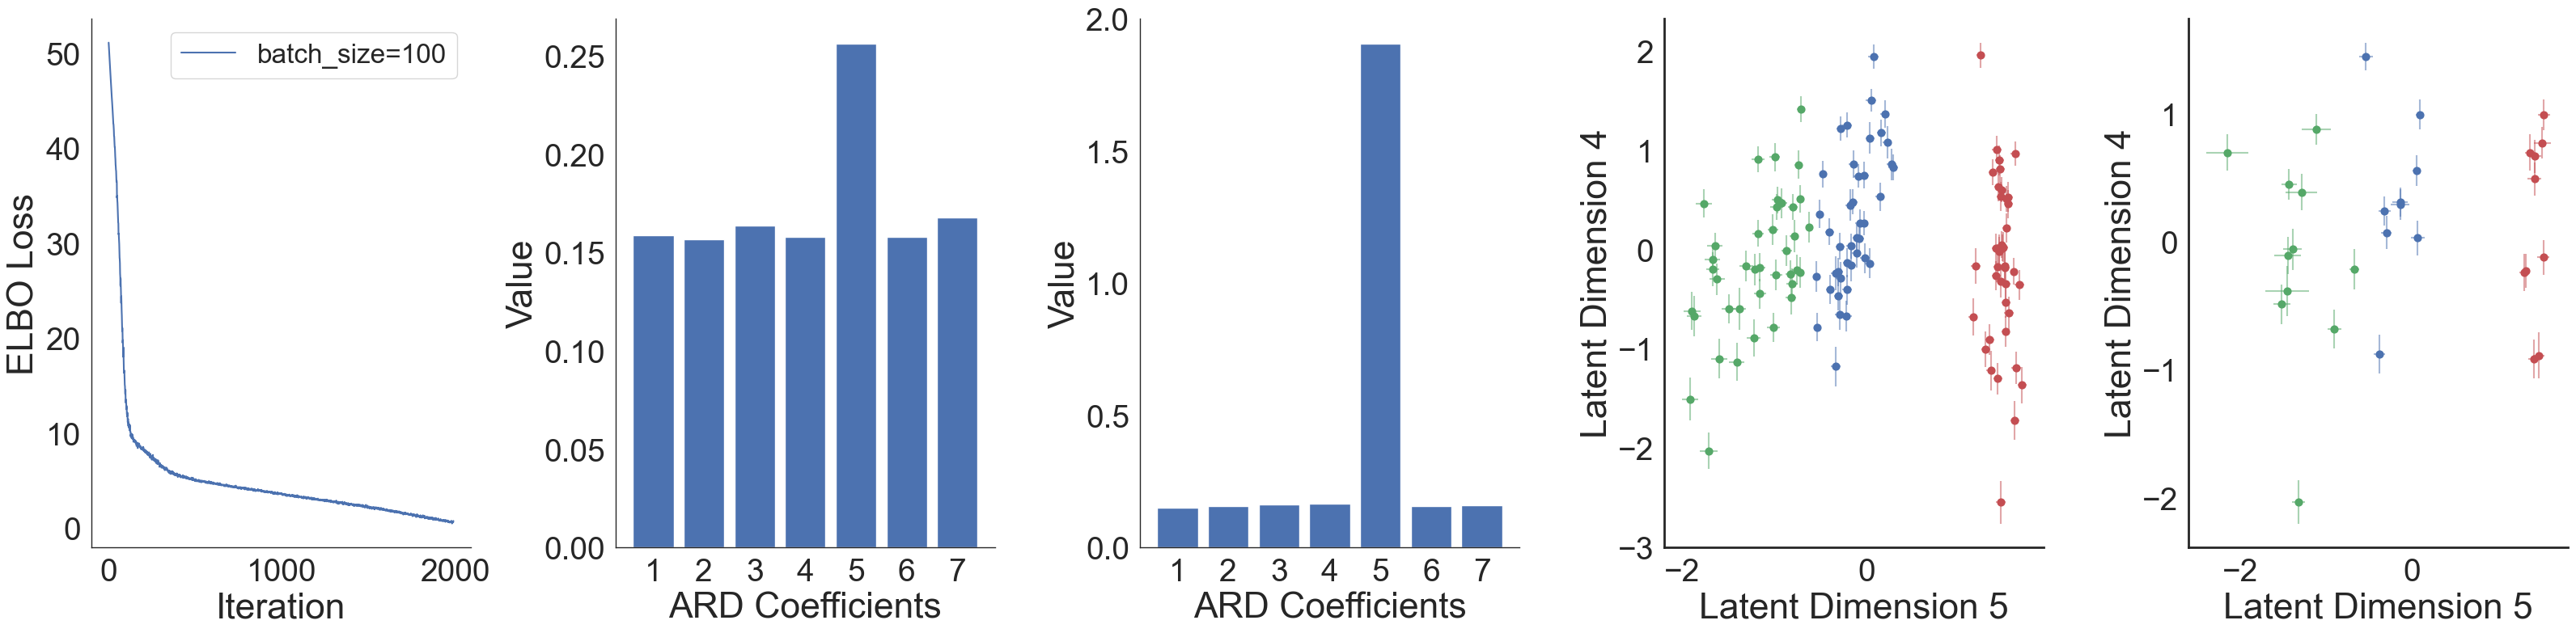

In [12]:
latent_dim = x_iris.shape[-1]
values, indices = torch.topk(torch.tensor(alpha_cls_iris), k=2, largest=True)
l1 = indices.numpy().flatten()[0]
l2 = indices.numpy().flatten()[1]

fig, axs = plt.subplots(1,5, figsize=(32, 8))


plot_loss_gplvm(losses_iris, ax=axs[0])
plot_ARD_gplvm(latent_dim, alpha_cls_iris, ax=axs[2])
plot_ARD_gplvm(latent_dim, alpha_reg_iris, ax=axs[1])
plot_scatter_gplvm(x_iris, labels_train_iris, l1=l1, l2=l2, ax=axs[3], colors=['r', 'b', 'g'], show_errorbars=True, std=std_iris)
plot_scatter_gplvm(x_test_iris, labels_test_iris, l1=l1, l2=l2, ax=axs[4], colors=['r', 'b', 'g'], show_errorbars=True, std=std_test_iris)
plt.tight_layout()

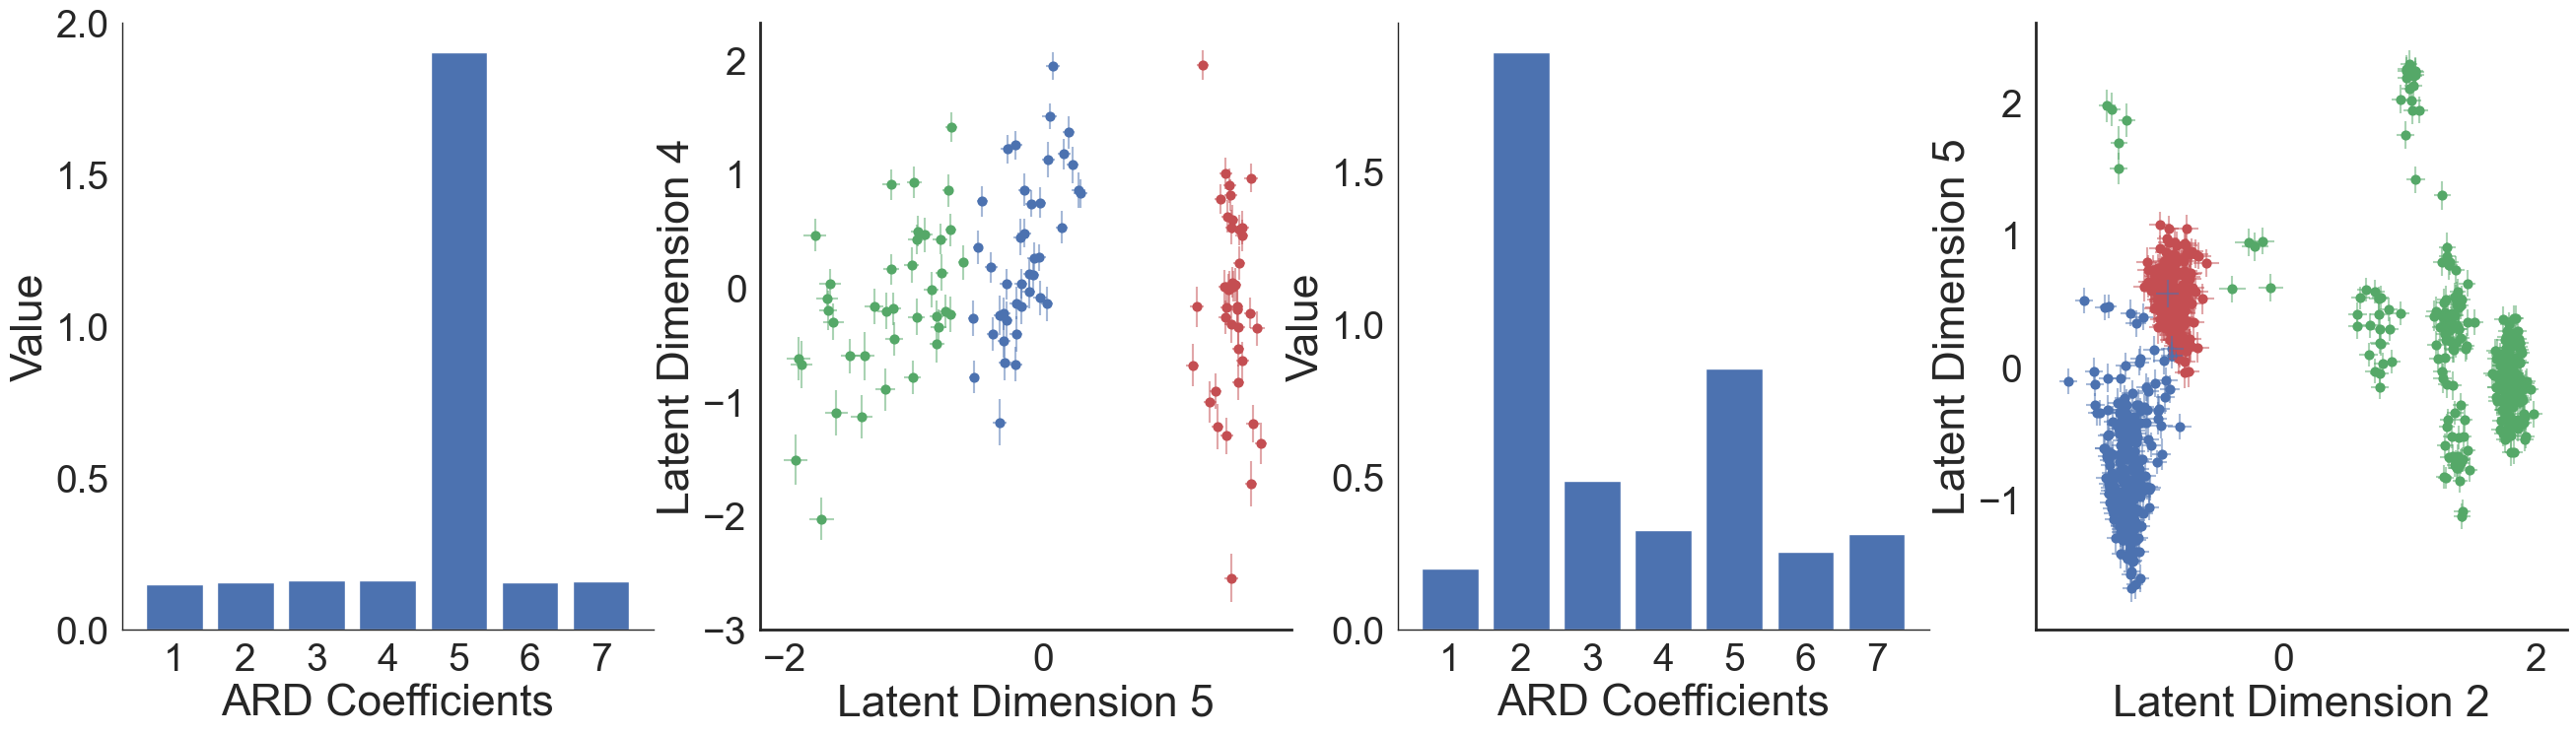

In [35]:
fig, axs = plt.subplots(1,4, figsize=(32, 8))

values, indices = torch.topk(torch.tensor(alpha_cls_iris), k=2, largest=True)
l1 = indices.numpy().flatten()[0]
l2 = indices.numpy().flatten()[1]

plot_ARD_gplvm(x_iris.shape[-1], alpha_cls_iris, ax=axs[0])
plot_scatter_gplvm(x_iris, labels_train_iris, l1=l1, l2=l2, ax=axs[1], colors=['r', 'b', 'g'], show_errorbars=True, std=std_iris)

values, indices = torch.topk(torch.tensor(alpha_cls_oil), k=2, largest=True)
l1 = indices.numpy().flatten()[0]
l2 = indices.numpy().flatten()[1]

plot_ARD_gplvm(x_oil.shape[-1], alpha_cls_oil, ax=axs[2])
plot_scatter_gplvm(x_oil, labels_train_oil, l1=l1, l2=l2, ax=axs[3], colors=['r', 'b', 'g'], show_errorbars=True, std=np.sqrt(std_oil))

fig.savefig("./saved_results/figure2.png")
fig.savefig("./saved_results/figure2.svg")
